# **TODO**
* phi features overfit?

# Import libraries

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from lib.proj1_helpers import * #the helper provided for the project

from implementations import * #our implementations of the functions done by us
from helpers import *
import datetime
import operator
# Useful starting lines

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Loading the training and the testing sets

In [2]:
DATA_FOLDER = 'data/'

y_train, tx_train, ids_train = load_csv_data(DATA_FOLDER+'train.csv',sub_sample=False)

y_test, tx_test, ids_test = load_csv_data(DATA_FOLDER+'test.csv',sub_sample=False)

In [3]:
y_train.shape

(250000,)

In [4]:
tx_train

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ..., 
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [5]:
tx_test

array([[-999.   ,   79.589,   23.916, ..., -999.   , -999.   ,    0.   ],
       [ 106.398,   67.49 ,   87.949, ..., -999.   , -999.   ,   47.575],
       [ 117.794,   56.226,   96.358, ..., -999.   , -999.   ,    0.   ],
       ..., 
       [ 108.497,    9.837,   65.149, ..., -999.   , -999.   ,    0.   ],
       [  96.711,   20.006,   66.942, ..., -999.   , -999.   ,   30.863],
       [  92.373,   80.109,   77.619, ..., -999.   , -999.   ,    0.   ]])

In [6]:
y_test

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [7]:
print(tx_train.shape)
print(tx_test.shape)
print(y_train.shape)
print(y_test.shape)

(250000, 30)
(568238, 30)
(250000,)
(568238,)


# Split jets

In [29]:
def split_jets_mask(tx):
    idx_cat = 22
    idx_mass = 0
    return {
        #0: tx[:,idx_cat] == 0 and tx[:,idx_mass] != -999,
        #4: tx[:,idx_cat] == 0 and tx[:,idx_mass] == -999,
        0: np.all([tx[:,idx_cat] == 1, tx[:,idx_mass] != -999], axis=0), # 1!!
        #5: np.all([tx[:,idx_cat] == 1, tx[:,idx_mass] == -999], axis=0), 
        #2: tx[:,idx_cat] == 2 and tx[:,idx_mass] != -999,
        #6: tx[:,idx_cat] == 2 and tx[:,idx_mass] == -999,
        #3: tx[:,idx_cat] == 3 and tx[:,idx_mass] != -999,
        #7: tx[:,idx_cat] == 3 and tx[:,idx_mass] == -999,
    }

# Handling missing values

In [9]:
def clean_missing_values(tx):
    nan_values = (tx==-999)*1
    for col in range(tx.shape[1]):
        column = tx[:,col][tx[:,col]!=-999]
        if len(column) == 0:
            median = 0
        else:
            median = np.median(column)
        tx[:,col][tx[:,col]==-999] = median
    return tx, nan_values

In [28]:
def keep_unique_cols(tx):
    # If two (or more) columns of tx are equal, keep only one of them
    unique_cols_ids = [1] #0
    for i in range(2,tx.shape[1]): #1
        id_loop = unique_cols_ids
        erase = False
        equal_to = []
        for j in id_loop:
            if np.sum(tx[:,i]-tx[:,j])==0:
                erase = True
                equal_to.append(j)
                break
        if erase == False:
            unique_cols_ids.append(i)
        #else:
        #    print('column', i, 'deleted because equal to column(s) ', equal_to)
            
    index = np.argwhere(unique_cols_ids==22)
    unique_cols_ids = np.delete(unique_cols_ids, index)
    
    return unique_cols_ids

# Add cross products between features

In [11]:
def add_cross_prod(tx, i, j):
    return np.concatenate((tx, np.array([tx[:,i]*tx[:,j]]).T), axis=1)

def add_all_cross_prod(tx):
    sh = tx.shape[1]
    for i in range(sh):
        #print(i)
        for j in range(i+1, sh):
            if i != j:
                tx = add_cross_prod(tx, i, j)
    return tx

# Build powers of features

In [12]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    return np.array([x**p for p in range(2,degree+1)]).T 
    # not range from 0 because we have already added a column of ones, 
    # not range from 1 because we already have the linear features.

In [13]:
def add_powers(tx, degree, first_data_id, len_init_data, features='x'):
    if features == 'x': # square roots of initial (kept) features
        range_c = range(first_data_id, first_data_id+len_init_data)
    elif features == 'cp': # square roots of cross products
        range_c = range(first_data_id, first_data_id+(len_init_data*(len_init_data-1))/2)
    else:
        raise NameError('Need to specity x (features) of cp (cross products)')
    for col in range_c: 
        tx = np.concatenate((tx, build_poly(tx[:,col], degree)), axis=1)
    return tx

# Add column of ones

In [14]:
def add_ones(tx):
    return np.concatenate((tx, np.ones([tx.shape[0],1])), axis=1)

# Build square roots of features !!! Check >0!!!

In [15]:
def add_square_root(tx, first_data_id, len_init_data, features='x'):
    if features == 'x': # square roots of initial (kept) features
        range_c = range(first_data_id, first_data_id+len_init_data)
    elif features == 'cp': # square roots of cross products
        range_c = range(first_data_id, first_data_id+(len_init_data*(len_init_data-1))/2)
    else:
        raise NameError('Need to specity x (features) of cp (cross products)')
    sqrt_array = np.array([np.sqrt(tx[:,c]) for c in range_c].T)
    return np.concatenate((tx, sqrt_array), axis=1)

# Summarize the step of data preparation

In [16]:
def prepare_data(train_tx, test_tx, deg):
    #print('Cleaning features')
    train_tx = clean_missing_values(train_tx)[0]
    test_tx = clean_missing_values(test_tx)[0]
    
    #print('Keeping unique cols')
    unique_cols = keep_unique_cols(train_tx)
    train_tx = train_tx[:,unique_cols]
    test_tx = test_tx[:,unique_cols]
    len_kept_data = len(unique_cols)
    
    #print('Standardizing')
    train_tx = standardize(train_tx)[0]
    test_tx = standardize(test_tx)[0]
    
    #print('Cross products')
    train_tx = add_all_cross_prod(train_tx)
    test_tx = add_all_cross_prod(test_tx)
    
    #print('Adding powers')
    train_tx = add_powers(train_tx, deg, 0, len_kept_data, 'x')
    test_tx = add_powers(test_tx, deg, 0, len_kept_data, 'x')
    
    #print('Adding ones')
    train_tx = add_ones(train_tx)
    test_tx = add_ones(test_tx)
    
    return train_tx, test_tx

# Plot accuracy evolution in function of the parameters

In [17]:
def plot_accuracy_evolution(degrees, lambdas, mean_acc_cv_train, mean_acc_cv_test, var_acc_cv_train, \
                            var_acc_cv_test):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

    # ---- First graph with respect to lambda ----
    ax = axes[0]
    nb_deg = len(degrees)
    colors = iter(cm.rainbow(np.linspace(0, 1, nb_deg)))
    
    for idx in range(nb_deg):
        c = next(colors)
        ax.semilogx(lambdas, mean_acc_cv_train[idx,:], linestyle="--", color=c, \
                         label='train, deg='+str(degrees[idx]))
        ax.semilogx(lambdas, mean_acc_cv_test[idx,:], linestyle="-", color=c, \
                         label='test, deg='+str(degrees[idx]))
        
    ax.legend()
    ax.set_xlabel("lambda")
    ax.set_ylabel("accuracy")
    ax.grid(True)
    
    # ---- Second graph with respect to degree ----
    ax = axes[1]
    nb_lambda = len(lambdas)
    colors2 = iter(cm.rainbow(np.linspace(0, 1, nb_lambda)))
    
    for idx in range(nb_lambda):
        c = next(colors2)
        ax.plot(degrees, mean_acc_cv_train[:,idx], linestyle="--", color=c, \
                         label='train, lambda='+str(lambdas[idx]))
        ax.plot(degrees, mean_acc_cv_test[:,idx], linestyle="-", color=c, \
                         label='test, lambda='+str(lambdas[idx]))
    
    ax.set_xlabel("degree")
    ax.set_ylabel("accuracy")
    ax.grid(True)
    ax.legend()
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    plt.show()


# Cross validation for ridge regression

In [18]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [19]:
def cleaned_ridge_regression_pred(single_degree, single_lambda, single_train_tx, single_test_tx, \
                                  single_train_y, single_test_y=[], predictions=True):
    # Clean and prepare data !!!!!!!!!TODO!!!!!!!!!! NOT HERE WOULD BE MORE EFFICIENT.......
    single_train_tx, single_test_tx = prepare_data(single_train_tx, single_test_tx, single_degree)

    # Compute the weights with ridge regression
    weights = ridge_regression(single_train_y, single_train_tx, single_lambda)

    # Compute the predictions
    y_pred_train = predict_labels(weights, single_train_tx)
    y_pred_test = predict_labels(weights, single_test_tx)
    
    # Compute accuracy of the predictions
    accuracy_train = np.sum(y_pred_train == single_train_y)/len(single_train_y)
    if len(single_test_y) != 0:
        accuracy_test = np.sum(y_pred_test == single_test_y)/len(single_test_y)
        if predictions==True:
            return y_pred_train, y_pred_test, accuracy_train, accuracy_test
        else:
            return accuracy_train, accuracy_test
    else:
        if predictions==True:
            return y_pred_train, y_pred_test, accuracy_train
        else:
            return accuracy_train

In [20]:
def cross_validation_single_jet_single_param_ridge_regression(single_jet_y, single_jet_tx, k_fold, seed, \
                                                              single_degree, single_lambda):
    # get k'th subgroup in test, others in train
    k_indices = build_k_indices(single_jet_y, k_fold, seed)
    accuracy_train = np.zeros(k_fold)
    accuracy_test = np.zeros(k_fold)
    
    for k in range(k_fold):
        #print('----- FOLD', k, '-----')
        k_index = k_indices[k]
        test_y = single_jet_y[k_index]
        test_tx = single_jet_tx[k_index,:]

        mask = np.ones(len(single_jet_y), dtype=bool) # set all elements to True
        mask[k_index] = False              # set test elements to False
        train_tx = single_jet_tx[mask,:]              # select only True elements (ie train elements)
        train_y = single_jet_y[mask]

        accuracy_train[k], accuracy_test[k] = \
            cleaned_ridge_regression_pred(single_degree, single_lambda, train_tx, test_tx, train_y, test_y, \
                                          predictions=False)
            
    return np.mean(accuracy_train), np.mean(accuracy_test), np.var(accuracy_train), np.var(accuracy_test), \
           np.min(accuracy_train), np.min(accuracy_test), np.max(accuracy_train), np.max(accuracy_test)

In [21]:
def cross_validation_single_jet_ridge_regression(degrees, lambdas, y_single_jet_train, tx_single_jet_train, \
                                                 k_fold, seed, returnAll=False):
    mean_acc_cv_train = np.zeros([len(degrees), len(lambdas)])
    mean_acc_cv_test = np.zeros([len(degrees), len(lambdas)])
    var_acc_cv_train = np.zeros([len(degrees), len(lambdas)])
    var_acc_cv_test = np.zeros([len(degrees), len(lambdas)])
    min_acc_cv_train = np.zeros([len(degrees), len(lambdas)])
    min_acc_cv_test = np.zeros([len(degrees), len(lambdas)])
    max_acc_cv_train = np.zeros([len(degrees), len(lambdas)])
    max_acc_cv_test = np.zeros([len(degrees), len(lambdas)])
    
    for i, single_degree in enumerate(degrees):
        print('!!!! DEGREE', single_degree, '!!!!')
        for j, single_lambda in enumerate(lambdas):
            print('--- LAMBDA', single_lambda, '---')
            mean_acc_cv_train[i,j], mean_acc_cv_test[i,j], var_acc_cv_train[i,j], var_acc_cv_test[i,j], \
                min_acc_cv_train[i,j], min_acc_cv_test[i,j], max_acc_cv_train[i,j], max_acc_cv_test[i,j] = \
                cross_validation_single_jet_single_param_ridge_regression(y_single_jet_train, tx_single_jet_train, \
                                                                          k_fold, seed, single_degree, single_lambda)

    max_id_deg, max_id_lambda = np.unravel_index(mean_acc_cv_test.argmax(), mean_acc_cv_test.shape)
    print('Best mean accuracy: ', mean_acc_cv_test[max_id_deg, max_id_lambda])
    print('attained with degree =', degrees[max_id_deg], 'and lambda =', lambdas[max_id_lambda])
    plot_accuracy_evolution(degrees, lambdas, mean_acc_cv_train, mean_acc_cv_test, var_acc_cv_train, var_acc_cv_test)

    if returnAll == True:
        return degrees[max_id_deg], lambdas[max_id_lambda], mean_acc_cv_train, mean_acc_cv_test, var_acc_cv_train, \
               var_acc_cv_test, min_acc_cv_train, min_acc_cv_test, max_acc_cv_train, max_acc_cv_test
    else:
        return degrees[max_id_deg], lambdas[max_id_lambda], mean_acc_cv_train[max_id_deg, max_id_lambda], \
               mean_acc_cv_test[max_id_deg, max_id_lambda]

In [23]:
def cross_validation_all_jets_ridge_regression(degrees, lambdas, k_fold, seed, full_y_train, full_tx_train, \
                                               full_tx_test):
    mask_jets_train = split_jets_mask(full_tx_train)
    mask_jets_test = split_jets_mask(full_tx_test)
        
    len_mask = len(mask_jets_train)
    best_degree = np.zeros(len_mask)
    best_lambda = np.zeros(len_mask)
    best_acc_train = np.zeros(len_mask)
    best_acc_test = np.zeros(len_mask)
    len_jets_train = np.zeros(len_mask)
    len_jets_test = np.zeros(len_mask)

    for mask_jet_id in range(len_mask):
        print('********** Jet ', mask_jet_id, '***********')
        tx_single_jet_train = full_tx_train[mask_jets_train[mask_jet_id]]
        tx_single_jet_test = full_tx_test[mask_jets_test[mask_jet_id]]
        y_single_jet_train = full_y_train[mask_jets_train[mask_jet_id]]
        len_jets_train[mask_jet_id] = len(y_single_jet_train)
        len_jets_test[mask_jet_id] = tx_single_jet_test.shape[0]
        
        best_degree[mask_jet_id], best_lambda[mask_jet_id], best_acc_train[mask_jet_id], best_acc_test[mask_jet_id] = \
            cross_validation_single_jet_ridge_regression(degrees, lambdas, y_single_jet_train, tx_single_jet_train, \
                                                         k_fold, seed, returnAll=False)
    best_degree = best_degree.astype(int)
    best_full_accuracy_train = \
        np.sum([best_acc_train[id]*len_jets_train[id] for id in range(len_mask)])/len(full_y_train)
    best_full_accuracy_test = \
        np.sum([best_acc_test[id]*len_jets_test[id] for id in range(len_mask)])/full_tx_test.shape[0]
        
    return best_degree, best_lambda, best_full_accuracy_train, best_full_accuracy_test

In [24]:
def ridge_regression_all_jets_pred(full_tx_train, full_tx_test, full_y_train, degrees, lambdas):
    mask_jets_train = split_jets_mask(full_tx_train)
    mask_jets_test = split_jets_mask(full_tx_test)
    
    len_mask = len(mask_jets_train)
    y_pred_train = np.zeros(len(full_y_train))
    y_pred_test = np.zeros(full_tx_test.shape[0])
    accuracy_train = np.zeros(len_mask)
    len_jets_train = np.zeros(len_mask)
    
    for mask_jet_id in range(len_mask):
        print('********** Jet ', mask_jet_id, '***********')
        tx_single_jet_train = full_tx_train[mask_jets_train[mask_jet_id]]
        tx_single_jet_test = full_tx_test[mask_jets_test[mask_jet_id]]
        y_single_jet_train = full_y_train[mask_jets_train[mask_jet_id]]
        len_jets_train[mask_jet_id] = len(y_single_jet_train)
        
        y_pred_train[mask_jets_train[mask_jet_id]], y_pred_test[mask_jets_test[mask_jet_id]], \
            accuracy_train[mask_jet_id] = cleaned_ridge_regression_pred(degrees[mask_jet_id], lambdas[mask_jet_id], \
                                                                        tx_single_jet_train, tx_single_jet_test, \
                                                                        y_single_jet_train, [], predictions=True)
    
    full_accuracy_train = \
        np.sum([accuracy_train[id]*len_jets_train[id] for id in range(len_mask)])/len(full_y_train)
        
    return y_pred_train, y_pred_test, full_accuracy_train
    

# RIDGE REGRESSION

********** Jet  0 ***********
!!!! DEGREE 3 !!!!
--- LAMBDA 1e-08 ---
--- LAMBDA 1e-07 ---
--- LAMBDA 1e-06 ---
--- LAMBDA 1e-05 ---
--- LAMBDA 0.0001 ---
--- LAMBDA 0.001 ---
--- LAMBDA 0.01 ---
--- LAMBDA 0.1 ---
!!!! DEGREE 4 !!!!
--- LAMBDA 1e-08 ---
--- LAMBDA 1e-07 ---
--- LAMBDA 1e-06 ---
--- LAMBDA 1e-05 ---
--- LAMBDA 0.0001 ---
--- LAMBDA 0.001 ---
--- LAMBDA 0.01 ---
--- LAMBDA 0.1 ---
!!!! DEGREE 5 !!!!
--- LAMBDA 1e-08 ---
--- LAMBDA 1e-07 ---
--- LAMBDA 1e-06 ---
--- LAMBDA 1e-05 ---
--- LAMBDA 0.0001 ---
--- LAMBDA 0.001 ---
--- LAMBDA 0.01 ---
--- LAMBDA 0.1 ---
!!!! DEGREE 6 !!!!
--- LAMBDA 1e-08 ---
--- LAMBDA 1e-07 ---
--- LAMBDA 1e-06 ---
--- LAMBDA 1e-05 ---
--- LAMBDA 0.0001 ---
--- LAMBDA 0.001 ---
--- LAMBDA 0.01 ---
--- LAMBDA 0.1 ---
Best mean accuracy:  0.769419834238
attained with degree = 4 and lambda = 0.1


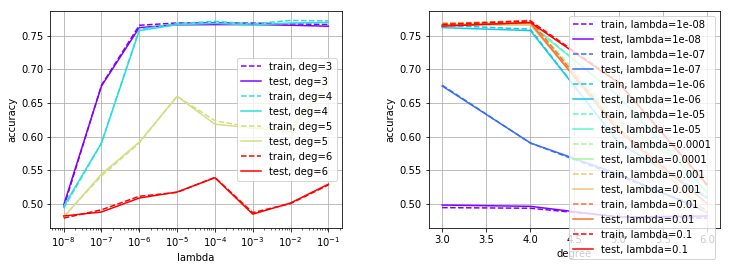

In [30]:
degrees = range(3,7)
lambdas = np.logspace(-8,-1,8)
k_fold = 4 #10
seed = 1

best_degree, best_lambda, best_mean_accuracy_train, best_mean_accuracy_test = \
    cross_validation_all_jets_ridge_regression(degrees, lambdas, k_fold, seed, y_train, tx_train, tx_test)

In [26]:
print(best_mean_accuracy_train)
print(best_mean_accuracy_test)
print(best_degree)
print(best_lambda)

0.246368785017
0.243888602282
[6 6]
[  1.00000000e-05   1.00000000e-06]


In [ ]:
y_pred_train, y_pred_test, full_accuracy_train, = \
    ridge_regression_all_jets_pred(tx_train, tx_test, y_train, best_degree, best_lambda)

In [ ]:
print(full_accuracy_train)

In [ ]:
print(y_pred_test[0:200])

In [ ]:
y_pred_test.shape

In [ ]:
print(y_pred_test[y_pred_test==-1].shape)

In [ ]:
print(y_pred_test[y_pred_test==1].shape)

In [ ]:
#name = 'output/ridge_regression_ondine_splitjet_2.csv'
#create_csv_submission(ids_test, y_pred_test, name)